# GPR figure and run times

*This notebook is to reproduce the results from the article. For more information see the article in the parent directory.*

In [1]:
import os
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

from empymod.model import gpr

# Style adjustments
%matplotlib inline
mpl.rcParams['figure.dpi'] = 300
mpl.rcParams['savefig.dpi'] = 300
mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.serif'] = 'Computer Modern Roman'
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['font.style'] = 'normal'

## Parameters
Parameters as in Hunziker et al., 2015

In [2]:
x = np.r_[0.001, np.arange(1, 201)*.02]  # X-coord from 0 to 4 m, spacing of 20 cm
y = np.zeros(x.size)                     # Y-coord = 0
zsrc = 0.0000001                         # Source depth just slightly below 0
zrec = 0.5                               # Receiver depth at 0.5 m
depth = [0, 1]                           # 1 layer of 1 m thickness between two half-spaces
eperm = [1, 9, 15]                       # El. permit. model
res = [1e23, 200, 20]                    # Resistivity model: air, 1st layer, 2nd layer
f = np.linspace(1, 2048, 2048)*10**6     # Frequencies from 1 to 2018 MHz

## Calculate GPR with `empymod` for FHT and QWE

The calculation is time intensive. It therefore stores the result in ./data, and only calculates it, if those files don't exist.

In [3]:
if os.path.isfile('./data/GPR-FHT.npz'):  # If results exist, load them
    gprFHT, t = np.load('data/GPR-FHT.npz')['gprFHT'], np.load('data/GPR-FHT.npz')['t']
    gprQWE, t2 = np.load('data/GPR-QWE.npz')['gprQWE'], np.load('data/GPR-QWE.npz')['t']

else:  # If not pre-calculated, run empymod
    # 1. FHT
    t, gprFHT = gpr([0, 0, zsrc], [x, y, zrec], depth, res, fc=250, ab=11, gain=3, epermH=eperm, epermV=eperm, 
                    ht='fht', htarg=['key_401_2009', ''], opt=None, loop='off', verb=1)

    np.savez('data/GPR-FHT', gprFHT=gprFHT, t=t)

    # 2. QWE
    t, gprQWE = gpr([0, 0, zsrc], [x, y, zrec], depth, res, fc=250, ab=11, gain=3, epermH=eperm, epermV=eperm,
                    ht='qwe', htarg=[1e-10, 1e-18, 21, 500], verb=1)
    np.savez('data/GPR-QWE', gprQWE=gprQWE, t=t)

## Calculate `EMmod` results

To re-calculate the `EMmod`-Result, `EMmod` must be installed and in the bash-PATH. Otherwise, you can use the result in ./data.

In [4]:
# Create EMmod results if it does not exist
if not os.path.isfile('./data/GPR/gprloop_twointmod_freq2000000_11.bin'):
    os.chdir('data/GPR')
    subprocess.run('bash gprloop_twointerface.scr', shell=True, stderr=subprocess.STDOUT, stdout=subprocess.PIPE)
    os.chdir('../..')

# Read data
fEM = np.zeros((f.size, x.size), dtype=complex)
for i in range(f.size):
    filename = 'data/GPR/gprloop_twointmod_freq'+str(i+1)+'000000_11.bin'
    tf = open(filename, 'rb')
    temp = np.fromfile(tf)
    fEM[i, :] = temp[x.size*2:x.size*4:2] + 1j*temp[x.size*2+1:x.size*4+1:2]
    
# Apply Wavelet
fc = 250*10**6
cfc = -(np.r_[0, f[:-1]]/fc)**2
fwave = cfc*np.exp(cfc)
datamat = fEM*fwave[:, None]

# Apply FFT
temp = datamat[::-1,:].conj()
temp = np.r_[np.zeros((1, temp.shape[1])), temp]
datamat1 = np.r_[temp, datamat[1:, :]]
ttdata = np.fft.fftshift(datamat1, 0)
tsdata = np.fft.ifft(ttdata, axis=0).real
nfreq = 2*f.size
dfreq = f[1]-f[0]
xxtdata = nfreq*np.fft.fftshift(tsdata*dfreq, 0)
dt = 1/(nfreq*dfreq)

# Apply Gain
tvec = np.linspace(-nfreq/2, nfreq/2-1, nfreq)*dt
gain = 1 + np.abs((tvec*10**9)**3)
gprdata = xxtdata.real*gain[:, None]
gprdata = gprdata[2048:, :].real

## Calculate theoretical arrival times

In [5]:
# Arrival times for direct wave
clight = 299792458
vel = clight/np.sqrt(eperm[1])
arrtime = np.sqrt((zsrc-zrec)**2 + x**2 + y**2)/vel

# Arrival times for reflected wave
arrtimeref = np.sqrt((np.abs(zsrc - depth[1]) + np.abs(zrec - depth[1]))**2 + x**2 + y**2)/vel

# Arrival times for refracted wave in the air
# This only works if ypos = 0
refractang = np.arcsin(vel/clight)
arrtimerefair = (np.abs(zsrc - depth[0])/np.cos(refractang) + np.abs(zrec - depth[0])/np.cos(refractang))/vel
arrtimerefair += (np.abs(x) - np.abs(zsrc - depth[0])*np.tan(refractang) - np.abs(zrec - depth[0])*np.tan(refractang))/clight

## Plot

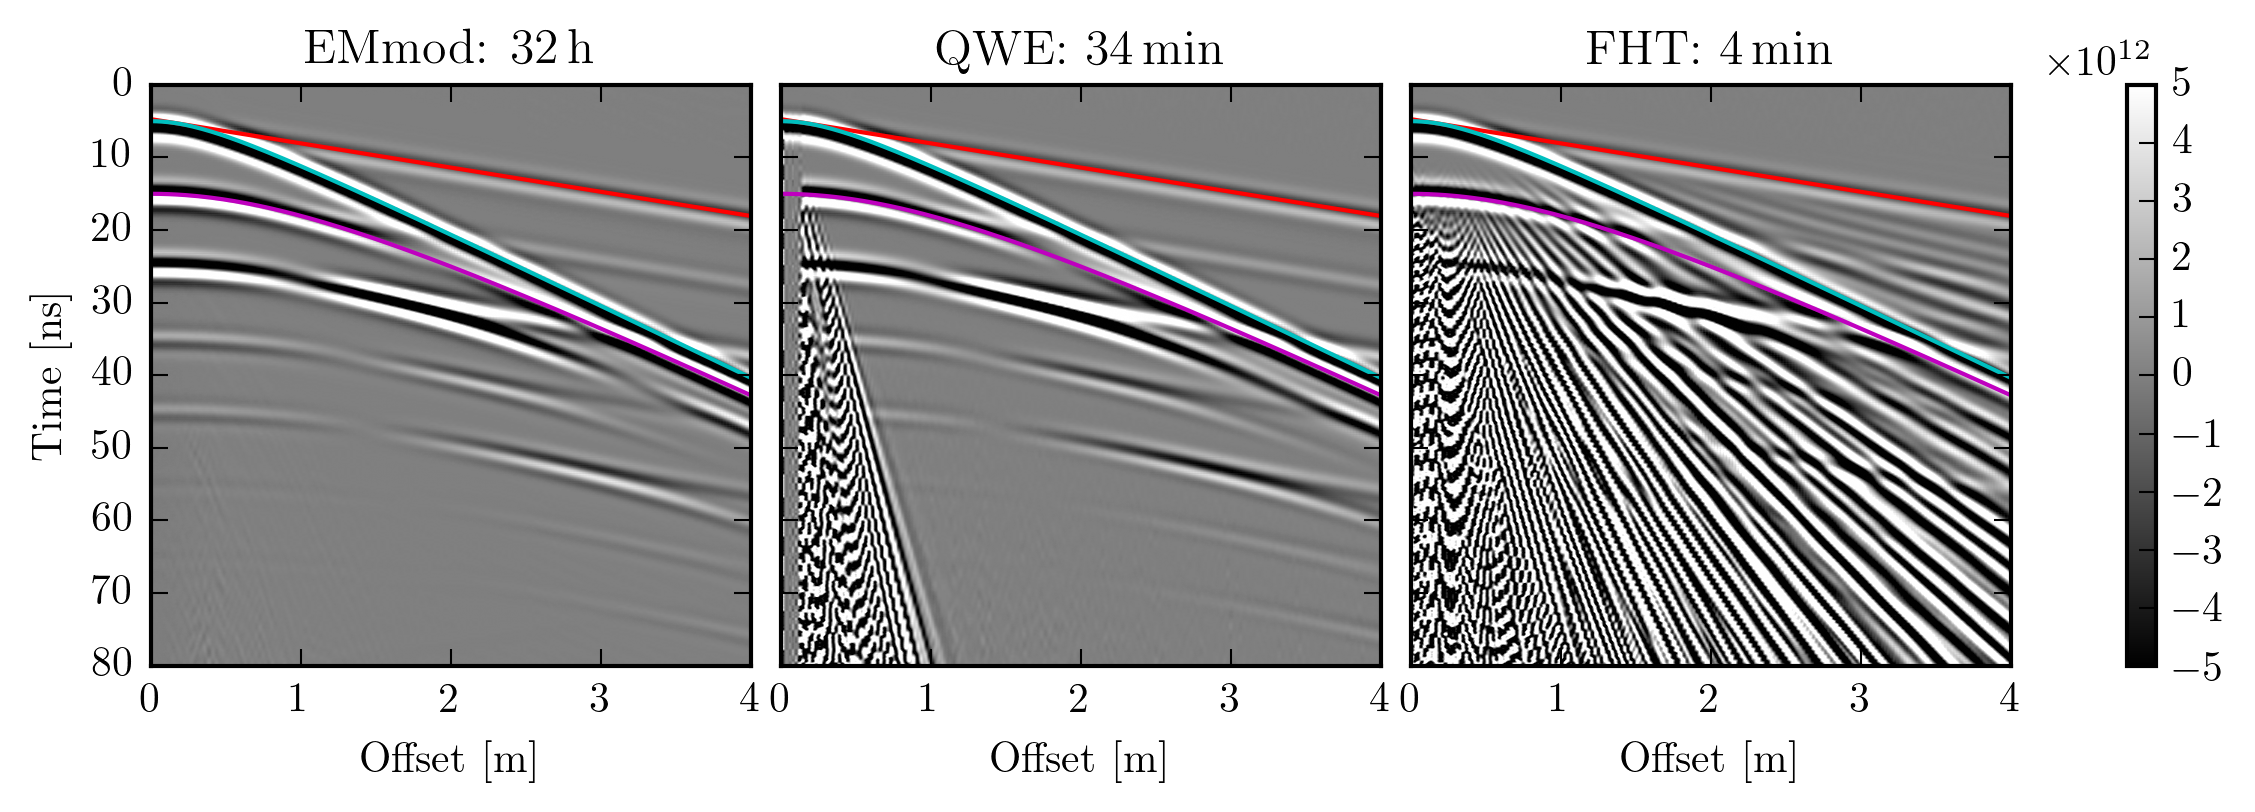

In [6]:
b = 328  # Max Time
tmax = t[b]*10**9

params = {'cmap':'gray', 'vmin':-.5*10**13, 'vmax':0.5*10**13, 'interpolation':'sinc',
          'extent':[0, 4, tmax, 0], 'aspect':'auto'}

fig, axs = plt.subplots(figsize=(10, 2.5), facecolor = 'w', nrows=1, ncols=3, sharex=True, sharey=True)
fig.subplots_adjust(wspace=.05)
axs = axs.ravel() 

# Set axis and limits
def limits(i):
    plt.sca(axs[i])
    plt.plot(x, arrtimerefair*10**9, 'r', lw=1)
    plt.plot(x, arrtime*10**9, 'c', lw=1)
    plt.plot(x, arrtimeref*10**9, 'm', lw=1)
    plt.ylim([tmax, 0])
    plt.xlim([0, 4])
    plt.xlabel('Offset [m]')
    plt.xticks(np.arange(5))
    plt.grid('off')

# Plot EMmod
limits(0)
plt.title(r'EMmod: 32\,h')
plt.imshow(gprdata[:b, :], **params)
plt.ylabel('Time [ns]')

# Plot QWE
limits(1)
plt.title(r'QWE: 34\,min')
plt.imshow(gprQWE[:b, :], **params)

# Plot FHT
limits(2)
plt.title(r'FHT: 4\,min')
plt.imshow(gprFHT[:b, :], **params)

# Plot colorbar
cax, kw = mpl.colorbar.make_axes([axs[0], axs[1], axs[2]], location='right')
cb = plt.colorbar(cax=cax, **kw)

# Save figure and show it
#plt.savefig('../figures/gpr.jpg', bbox_inches='tight')
plt.show()

## Run times of `EMmod` and `empymod`

As this big model takes a long time, `timeit` is set-up to run the code only 1 time.

In [7]:
print('Run time empymod - FHT')
%timeit -n 1 -r 1 gpr([0, 0, zsrc], [x, y, zrec], depth, res, fc=250, ab=11, gain=3, epermH=eperm, epermV=eperm, ht='fht', htarg=['key_401_2009', ''], opt=None, loop='off', verb=0)

print('\nRun time empymod - QWE')
%timeit -n 1 -r 1 gpr([0, 0, zsrc], [x, y, zrec], depth, res, fc=250, ab=11, gain=3, epermH=eperm, epermV=eperm, ht='qwe', htarg=[1e-10, 1e-18, 21, 500], verb=0)

print('\nRun time EMmod')
os.chdir('data/GPR')
%timeit -n 1 -r 1 subprocess.run('bash gprloop_twointerface.scr', shell=True, stderr=subprocess.STDOUT, stdout=subprocess.PIPE)
os.chdir('../..')

Run time empymod - FHT
* WARNING :: GPR FUNCTION IS IN DEVELOPMENT, USE WITH CAUTION
1 loop, best of 1: 4min 6s per loop

Run time empymod - QWE

Run time EMmod
